In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from matplotlib.animation import FuncAnimation
from scipy.ndimage import median_filter

# Single Aggregate Extraction

Extract manually the subregion/single aggregate region. Save the image data in .h5 file. 

Possible visualisation of single aggregate development with video. 

In [2]:
# Find out all the dataset names in the h5 file. 
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(h5_file_path, 'r') as h5file:
    for dataset_name in h5file:
        print(f"Dataset Name: {dataset_name}")

Dataset Name: green
Dataset Name: red


In [3]:
# Extract the data information.
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(h5_file_path, "r") as h5f:
    green_channel = h5f["green"][:]
    red_channel = h5f["red"][:]

In [4]:
# plt.imshow(green_channel[300])
# plt.imshow(green_channel[300][460:590, 40:160])

In [5]:
def extract_single_aggregate(channel):
    # Extract information from the dataset with given channel. 
    # Extract the image information for al frames. 
    aggregate = []
    for i in range(np.shape(channel)[0]):
        aggregate.append(channel[i][360:510, 630:770]) # Manually fit the region of aggregate!
    return np.array(aggregate)

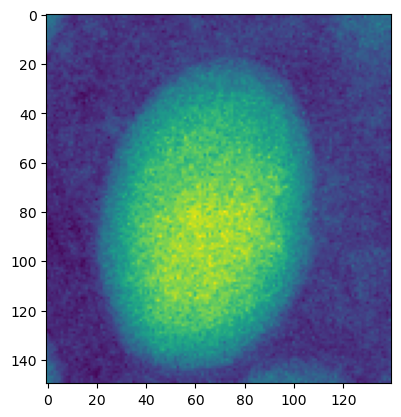

In [6]:
# Generate the subregion of images. 
aggregate = extract_single_aggregate(green_channel)
np.shape(aggregate) # (number of frames, y coordinate, x coordinate) dimensional 

# Save the all frames of subregion into .h5 file. 
h5_file_path = "single_aggregate_cut1(2)_v1.h5"
with h5py.File(h5_file_path, "w") as h5f:
     h5f.create_dataset("green", data = aggregate)

plt.imshow(aggregate[300])

In [43]:
# # Make the video for single aggregat# fig = plt.figure(figsize = (5, 5), dpi=300)
# fig = plt.figure(figsize = (5, 5), dpi=300)
# def make_frame(i):
#     plt.clf()
#     # Plotting.
#     plt.title("t="+str(i))
#     plt.imshow(aggregate[i])
#     print("tu")

# myanim = FuncAnimation(fig, make_frame, frames = np.shape(aggregate)[0]-1, interval = 500)
# myanim.save("single_aggregate_tissue1.mp4", writer="ffmpeg")

# Calculation of Polarisation: 
1. Get the vector from one pixel to the center and normalize the vector.
2. Multiple the vector with the current pixel intensity.
3. Do 1. and 2. for all pixels in the defined area from mask filter. Add them up --> A final vector.
The final vector points to the direction of polarisation and the length of the vector indicates the strength of polarisation. 

In [2]:
def polarisation_vector(center_x, center_y, radius, img):
    # Calculation of the ploarisation score and vector (as described in the caption above). 
    # Return the score and x,y components of the polarisation for given image.
    
    # Apply the circle mask to extract region of interest.
    circle_region = circle_mask(center_x, center_y, radius, img)
    # Find coordinates of all non-zero elements
    non_zero_indices = np.argwhere(circle_region != 0)
    
    # Calculate vector components from the center to each non-zero element
    dy = non_zero_indices[:, 0] - center_y
    dx = non_zero_indices[:, 1] - center_x
    
    # Calculate the magnitude of each vector
    magnitude = np.sqrt(dx**2 + dy**2)
    
    # Avoid division by zero for any points exactly at the center
    magnitude[magnitude == 0] = 1
    
    # Normalize the vectors
    normalized_dx = dx / magnitude
    normalized_dy = dy / magnitude
    
    # Get the values of each non-zero element
    values = circle_region[non_zero_indices[:, 0], non_zero_indices[:, 1]]
    
    # Multiply vectors by corresponding non-zero values
    weighted_dx = normalized_dx * values
    weighted_dy = normalized_dy * values
    
    # Sum up the weighted vectors.
    sum_dx = np.sum(weighted_dx)
    sum_dy = np.sum(weighted_dy)

    # Final score would be the magnitude of the sumed up vector.
    magnitude_sum_vector = np.sqrt(sum_dx**2 + sum_dy**2)

    return magnitude_sum_vector, sum_dx, -sum_dy

# Mask Filter 
1. Could filter the aggregate out and apply for area definition.
2. Filter out the pixels which has the distance to center smaller than or equal R --> approximatly a circle.
3. Apply the polarisation score function to determine the (reference) polarisation vector. --> for other analysis. 

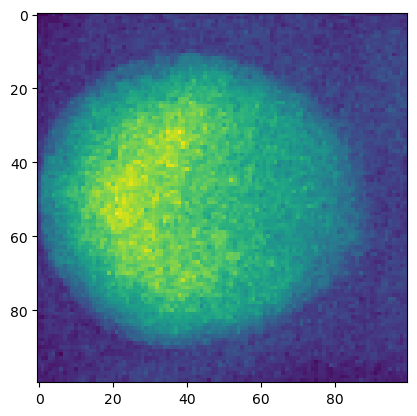

In [24]:
# Red in the single aggregate subregion image. (could for example be generated with capture "single aggregate extraction").
h5_file_path = "F:/PhD_Franziska/Headon/Polarisatioin/single_aggregate_cut1_h2.h5"
with h5py.File(h5_file_path, "r") as h5f:
    single_aggregate = h5f["green"][:]

#plt.imshow(single_aggregate[300])

In [25]:
def circle_mask(center_x, center_y, radius, img):
    # Extract a circle on the image with given center and radius.
    # center_x, center_y: integers. Define the center pixel of circle.
    # radius: integer. 
    
    # Create a grid of coordinates
    height, width = np.shape(img)[:2]
    Y, X = np.ogrid[:height, :width]
    
    # Calculate the mask for the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    circular_mask = distance_from_center <= radius
    
    # Apply the mask to get pixels within the circle
    circular_region = np.zeros_like(img)
    circular_region[circular_mask] = img[circular_mask]
    
    return circular_region

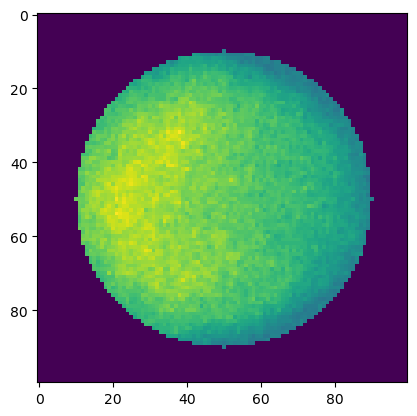

In [40]:
# circle_region = circle_mask(50, 50, 40, single_aggregate[300])
# plt.imshow(circle_region)

## Generate reference polarisation vector based on polarisation score function. 

In [43]:
# Only take the 300th frame for determination of reference polarisation vector. 

def one_frame_ref_pol_vec(center_x, center_y, radius, t, img_series):
    ref_pol_vec = np.array(polarisation_vector(center_x, center_y, radius, img_series[t])[1:3])
    normalised_ref_pol_vec = ref_pol_vec / np.linalg.norm(ref_pol_vec)
    return normalised_ref_pol_vec

#one_frame_ref_pol_vec(50, 50, 40, 300, single_aggregate)

array([-0.99996855,  0.00793029])

In [42]:
# Take a series of frames and take the mean polarisation vector as final reference polarisation vector. 

def mean_reference_polarisation_vector(t0, t1, center_x, center_y, radius, img_series):
    
    ref_pol_vec = []
    # Iterration over time points. 
    for i in range(t0, t1):
        ref_pol_vec.append(np.array(polarisation_vector(center_x, center_y, radius, img_series[i])[1:3]))
        
    # Stack the vectors into a single 2D array for easier manipulation
    all_ref_vec = np.stack(ref_pol_vec)

    # Compute the mean of x-values (column 0) and y-values (column 1)
    mean_x = np.mean(all_ref_vec[:, 0])  # Mean of all x-values
    mean_y = np.mean(all_ref_vec[:, 1])  # Mean of all y-values

    # Final reference vector is the mean over all frame vectors. Normalise the components.
    final_mean_ref_vec = np.array([mean_x, mean_y]) / np.linalg.norm(np.array([mean_x, mean_y]))

    return final_mean_ref_vec

#final_mean_ref_vec = mean_reference_polarisation_vector(290, 310, 50, 50, 40, single_aggregate)
#final_mean_ref_vec

array([-0.99973354,  0.02308335])

# Statistical Analysis of polarisation vector
1. The temporal dynamics of length of polarisation vector --> The strength of polarisation over time. Every frame has the same center and the region that will be considered to calculate the polarisation score.
2. Gather some single aggregates together and make the mean value statistics.

In [49]:
def temperal_polarisation(img_series, center_x, center_y, radius, time_conversion):
    # Calculate the polarisation score for all frames (with conversion into minute) in the img_series. 
    total_frame = np.shape(img_series)[0]

    polarisation_score = np.zeros(total_frame)
    for i in range(total_frame):
        polarisation_score[i] = polarisation_vector(center_x, center_y, radius, img_series[i])[0]

    # plt.figure(figsize=(5, 2), dpi=300)
    # # Convert frame into minutes with time_conversion.
    # frame_to_min = np.array([i for i in range(total_frame)])*time_conversion
    # # Plot the results in the background. 
    # plt.plot(frame_to_min, polarisation_score, c = "green", alpha=0.3, zorder=0)
    # # Plot the median filter at the top. 
    # plt.plot(frame_to_min, median_filter(polarisation_score, size=30, mode="nearest"), c="green", zorder=1)
    # # Add verticle line: highlight the frame where the velocity is maximal (from RedBeads/PIV_postprocessing)
    # plt.axvline(x = maxi_velocity_frame * time_conversion, color="red")
    # plt.xlabel("time (min)")
    # plt.ylabel("polarisation")
    # plt.show()
    
    return polarisation_score

In [50]:
def normalisation_polarisation_score(img_series, center_x, center_y, radius, time_conversion, maxi_velocity_frame, normalise_factor):
    # Calculate the polarisation score. 
    polarisation_score = temperal_polarisation(img_series, center_x, center_y, radius, time_conversion)
    # Normalise it by the normalise factor: manually determined by the value from first plateau.
    normalised_polarisation_score = polarisation_score  / normalise_factor

    # polarisation score for all frames (with conversion into minute) in the img_series. 
    total_frame = np.shape(img_series)[0]

    # Plot the normalised polarisation score.  
    plt.figure(figsize=(5, 2), dpi=300)
    # Convert frame into minutes with time_conversion.
    frame_to_min = np.array([i for i in range(total_frame)])*time_conversion
    # Plot the results in the background. 
    plt.plot(frame_to_min, normalised_polarisation_score, c = "green", alpha=0.3, zorder=0)
    # Plot the median filter at the top. 
    plt.plot(frame_to_min, median_filter(normalised_polarisation_score, size=30, mode="nearest"), c="green", zorder=1)
    # Add verticle line: highlight the frame where the velocity is maximal (from RedBeads/PIV_postprocessing)
    plt.axvline(x = maxi_velocity_frame * time_conversion, color="red")
    plt.xlabel("time (min)")
    plt.ylabel("polarisation")
    plt.savefig("polarisation_score_h2.svg", format="svg")
    plt.show()

    #return normalised_polarisation_score

In [51]:
#temperal_polarisation(single_aggregate, 50, 50, 40, 15)

array([ 11102.00325019,  11426.09040744,  10390.62338697,   9414.85865177,
         7357.27413828,   4404.49218724,  11221.67738086,   8962.86746191,
         8780.2138052 ,   5643.2746748 ,   3847.4453166 ,   4312.9962002 ,
         1455.95293618,   1626.71556074,   3731.79742275,   4771.51564743,
         9055.68673644,   9064.75379858,   8715.6722799 ,  12236.74074194,
        10133.08801203,   8635.18830383,   6966.32293992,   6559.93698011,
         9423.26803337,   5189.48646815,   7498.33189642,   7784.88543895,
         8743.83809581,   7421.64042135,   9211.24167339,  10708.46964658,
         8386.10615196,   6338.8124456 ,   8978.5686585 ,   7557.05807091,
         7670.25940184,   9123.7023774 ,   7028.83109364,   4576.77574734,
         3634.12120409,   7373.13105214,   4893.37267351,   7224.98119   ,
         9789.3512482 ,  14616.70993276,  12698.03591052,  10280.99022043,
        11881.97663893,  11634.0001753 ,  11339.46960333,  12584.12501384,
        10397.71759327,  

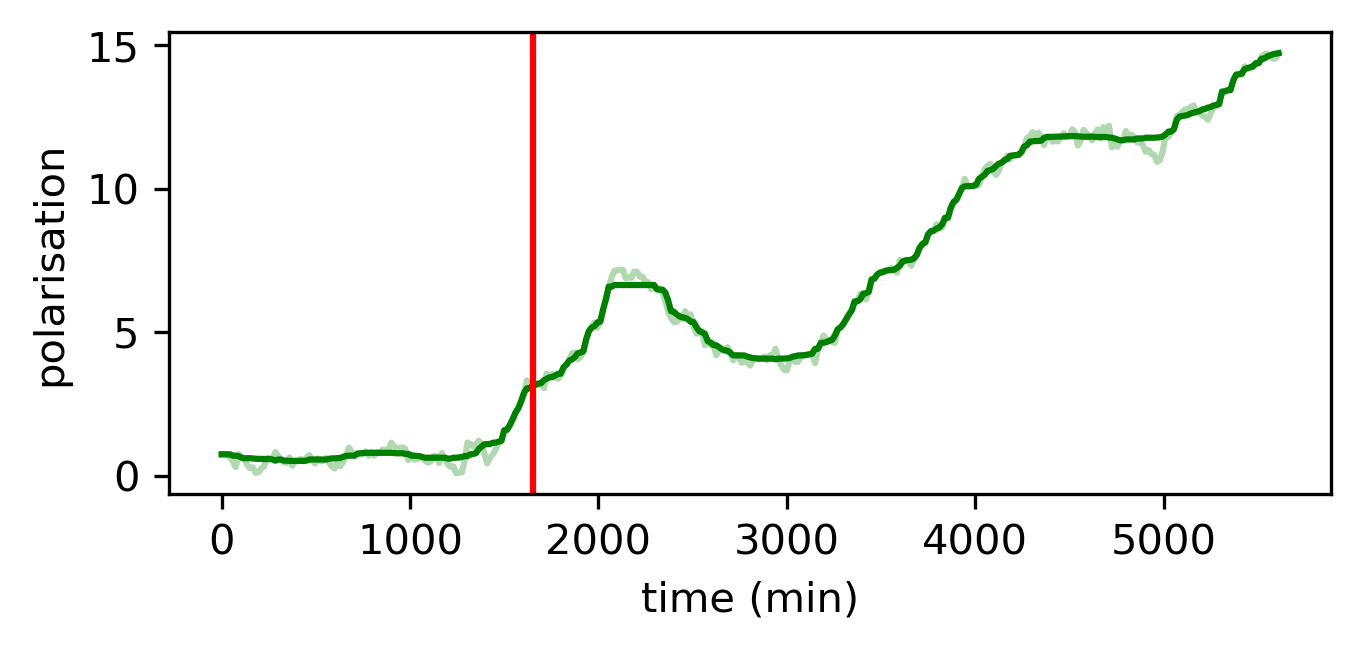

In [52]:
#normalisation_polarisation_score(single_aggregate, 50, 50, 40, 15, 110, 15000)